***Installing packages***

In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

***Reading .csv file with pandas***

In [7]:
df= pd.read_csv("C:/Users/davja/Downloads/conversion_data.csv")
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [10]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


***Print out information about unique values in each column of a DataFrame***

In [25]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:10])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
converted                2	 [0, 1]


***Checking if there is invalid inputs in the column of age***

*Set the maximum age is to be 100, more than 100 seems unrelealistic*

In [29]:
df[df['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


*Removing those 2 columns*

In [31]:
df = df[df['age']<100]

***EDA (Exploratory Data Analysis)***

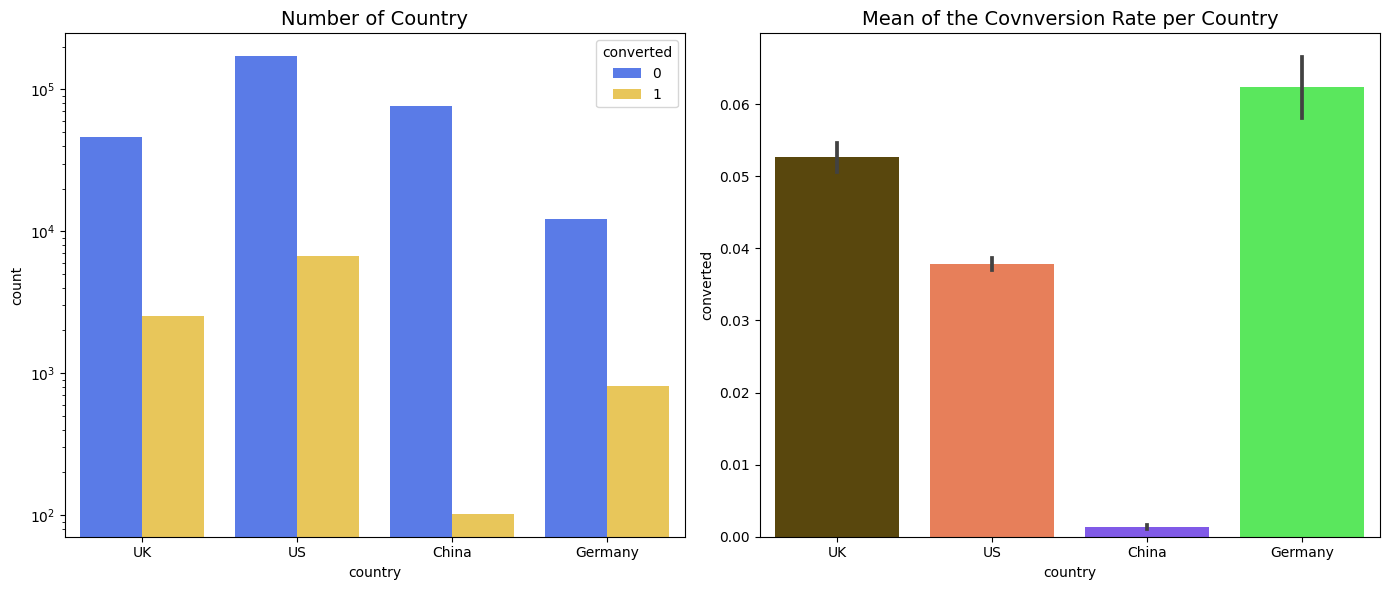

In [59]:
#Visualizing countries
Groups = df[['country', 'converted']].groupby('country').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,6))
sns.countplot(x='country', hue='converted', data=df, ax=ax[0], palette=['#426eff',"#ffd343"])
ax[0].set_title('Number of Country', fontsize = 14)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=df, ax=ax[1], palette=['#664e00',"#ff7442", "#7542ff", "#42ff46"])
ax[1].set_title('Mean of the Covnversion Rate per Country', fontsize = 14)
plt.tight_layout()
plt.show()


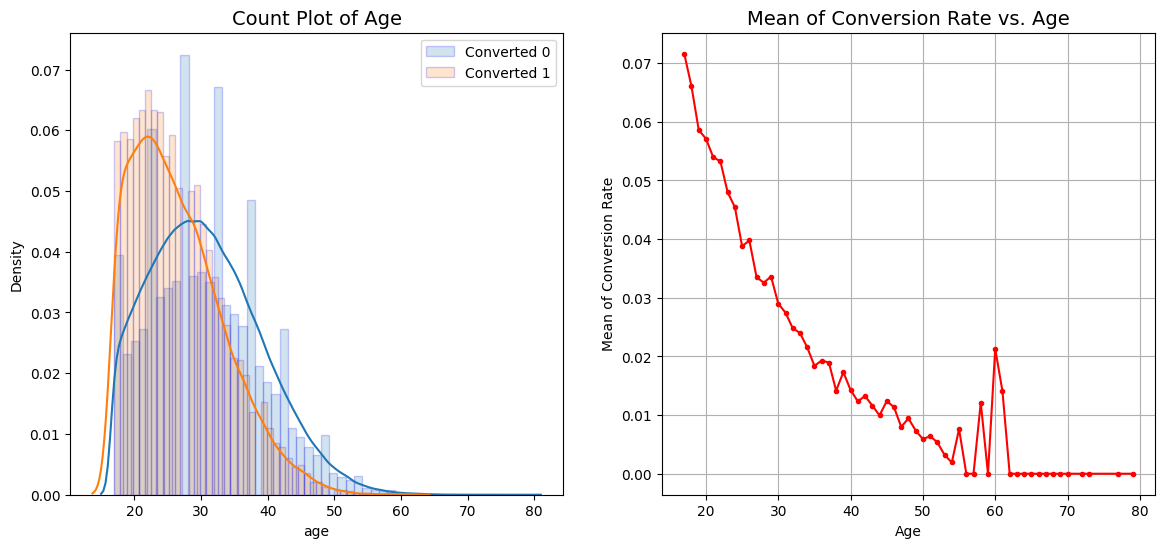

In [67]:
# Visualization of different sources
grouping = df[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor': 'blue', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.distplot(df[df['converted']==0]['age'], label='Converted 0',
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted']==1]['age'],label='Converted 1',
             ax=ax[0], hist_kws=hist_kws)

ax[0].set_title('Count Plot of Age', fontsize = 14)
ax[0].legend()
ax[1].plot(grouping['age'], grouping['converted'], '.-', color='red')
ax[1].set_title('Mean of Conversion Rate vs. Age', fontsize=14)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Mean of Conversion Rate')
ax[1].grid(True)
plt.show()

**Machine Learning**

In [4]:
#Make sure that to install Java Development Kit 
# Set up Java Environment Variables

In [3]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from C:\Users\davja\AppData\Roaming\Python\Python311\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\davja\AppData\Local\Temp\tmp9j2crlu5
  JVM stdout: C:\Users\davja\AppData\Local\Temp\tmp9j2crlu5\h2o_davja_started_from_python.out
  JVM stderr: C:\Users\davja\AppData\Local\Temp\tmp9j2crlu5\h2o_davja_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Australia/Sydney
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_davja_xz6cew
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.481 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [9]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(df)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.show_summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.569857685009246,,,4.872966476913342,
maxs,,123.0,,,29.0,
sigma,,8.271801801807747,,,3.3411037579481966,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [10]:
# Split into 80% training and 20% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.20, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'


In [11]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1707026110542_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         3.28311e+06            19           20           19.96         1693          3163          2604.84

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11774806948012574
RMSE: 0.34314438576221196
LogLoss: 0.37716602620455664
Mean Per-Class Error: 0.04164011437908497
AUC: 0.9926876996344222
AUCPR: 0.9914825272789177
Gini: 0.9853753992688443

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02798582605615969
       0       1       Error    Rate
-----  ------  ------  -------  ------------------
0      231269  13531   0.0553   (13531.0/244800.0)
1      6856    237944  0.028    (6856.0/244800.0)
Total  238125  251475  0.0416   (20387.0/489600.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0279858    0.95892   376
max f2                       0.00975591   0.976274  387
max f0point5                 0.0980624    0.962016  348
max accuracy                 0.0322201    0.958425  374
max precision                0.995752     0.999716  2
max recall                   0.00215145   1         394
max specificity              0.999433     0.999996  0
max absolute_mcc             0.0279858    0.917061  376
max min_per_class_accuracy   0.0427752    0.95748   369
max mean_per_class_accuracy  0.0322201    0.958425  374
max tns                      0.999433     244799    0
max fns                      0.999433     243932    0
max fps                      7.39121e-05  244800    399
max tps                      0.00215145   244800    394
max tnr                      0.999433     0.999996  0
max fnr                      0.999433     0.996454  0
max fpr                      7.39121e-05  1         399
max tpr                      0.00215145   1         394

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.98 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.99364            1.99918   1.99918            0.999592         0.996438     0.999592                    0.996438            0.0199918       0.0199918                  99.9183   99.9183            0.0199837
2        0.02                        0.989446           1.99837   1.99877            0.999183         0.991531     0.999387                    0.993984            0.0199837       0.0399755                  99.8366   99.8775            0.039951
3        0.03                        0.984978           1.99755   1.99837            0.998775         0.987299     0.999183                    0.991756            0.0199755       0.059951                   99.7549   99.8366            0.059902
4        0.04                        0.979297           1.99755   1.99816            0.998775         0.982216     0.999081                    0.989371            0.0199755       0.0799265                  99.7549   99.8162            0.0798529
5        0.05                        0.973199           1.99673   1.99788            0.998366      

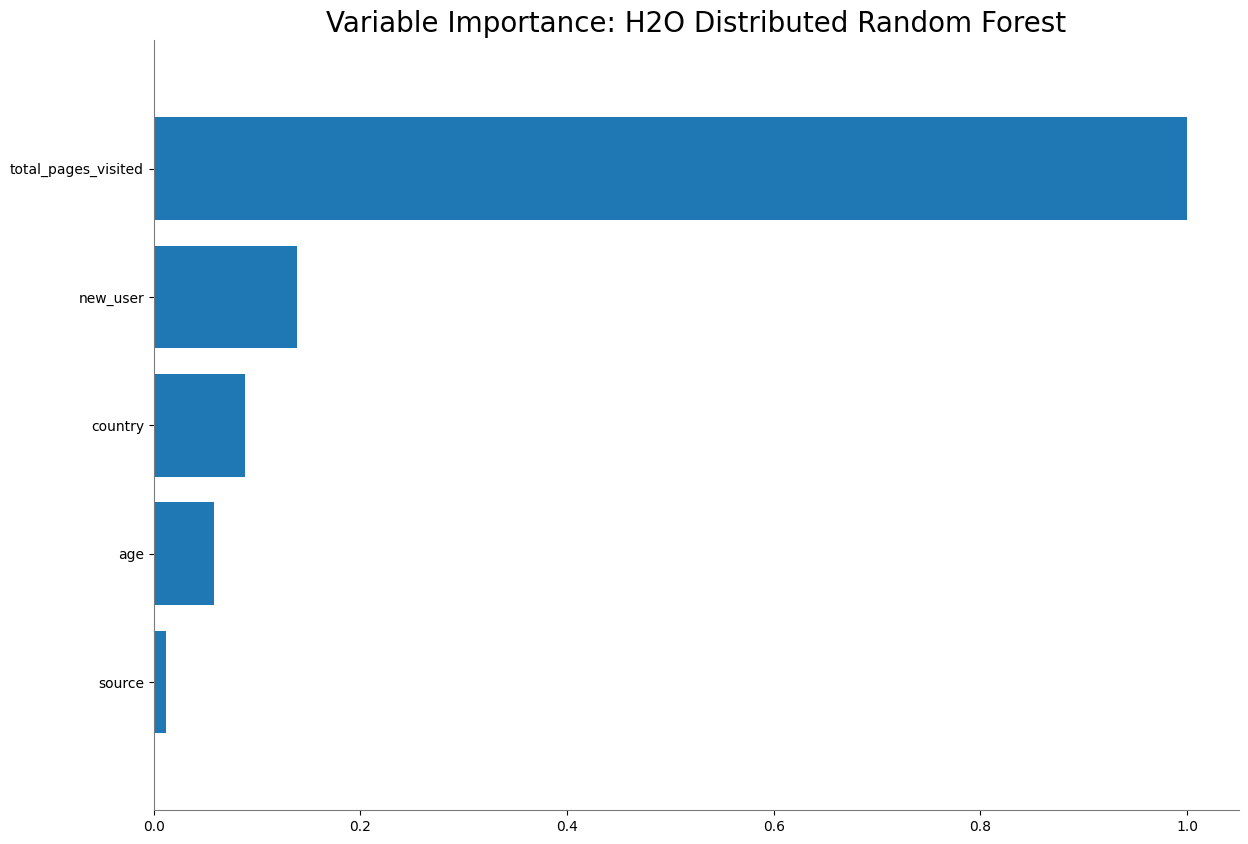

<Figure size 640x480 with 0 Axes>

In [12]:
model.varimp_plot()

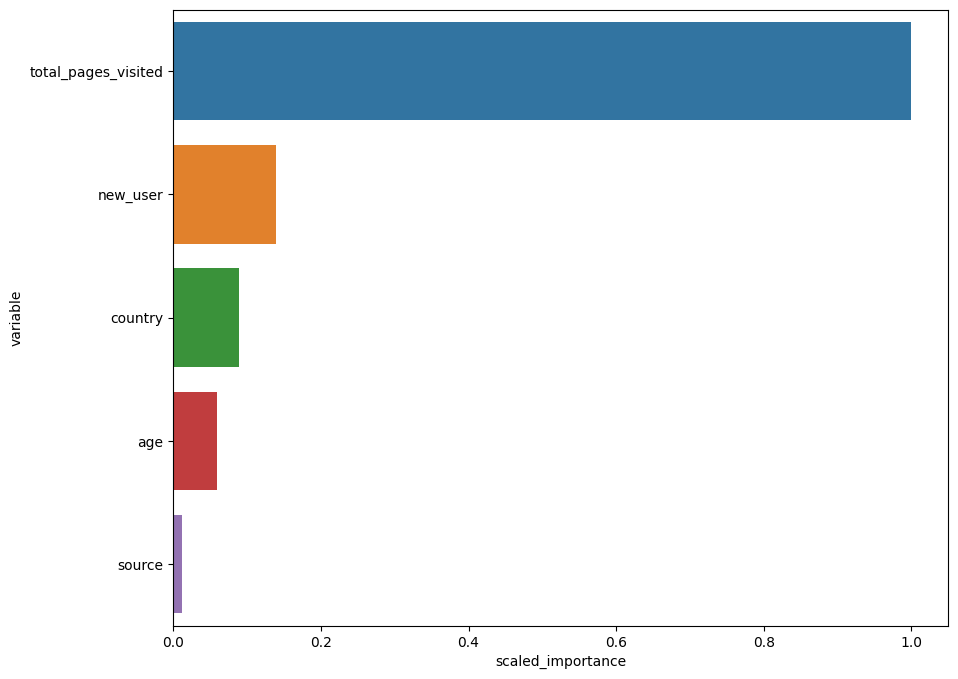

In [13]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [14]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

C:\Users\davja\AppData\Roaming\Python\Python311\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\davja\AppData\Roaming\Python\Python311\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\davja\AppData\Roaming\Python\Python311\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\davja\AppData\Roaming\Python\Python311\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


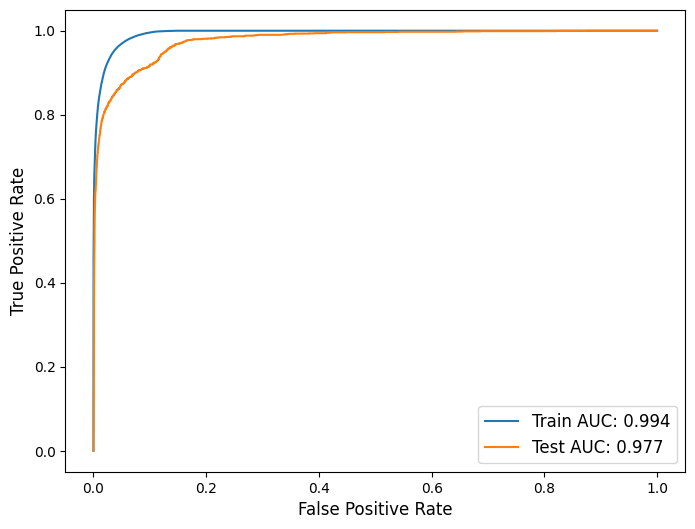

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


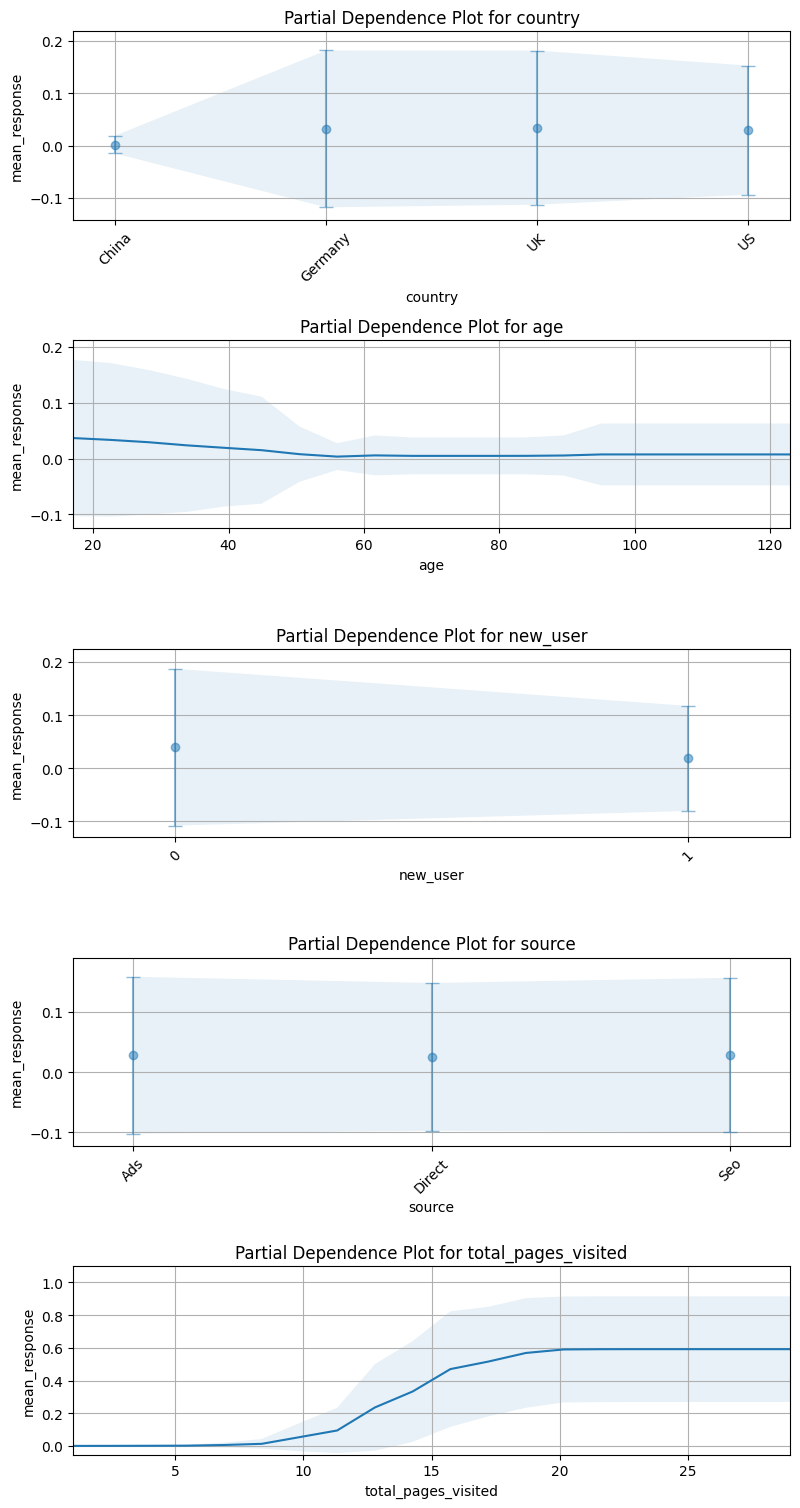

In [16]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))